In [30]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,SeparableConv2D, MaxPooling2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from numpy import loadtxt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
debug = True

outputs = pd.read_csv("/kaggle/input/combined-dataset-before-smote/output-2.csv", header=None, delimiter=',')
outputs = outputs.filter([26,27,28,29])
print(outputs)
all_scores = {}
batch_size = 16
epochs = 30

        26  27  28  29
0        1   0   0   1
1        1   1   0   0
2        0   1   1   0
3        0   1   0   0
4        1   1   0   0
...     ..  ..  ..  ..
147108   0   0   0   0
147109   0   0   1   1
147110   1   1   1   0
147111   0   0   0   1
147112   0   0   0   1

[147113 rows x 4 columns]


In [31]:
inputs = pd.read_csv("/kaggle/input/synthetic-dataset-with-pca/Synthetic_Dataset_with_PCA.csv", delimiter = ',')
inputs = inputs.drop(columns=['Unnamed: 0'])
print(inputs)

               0         1         2         3         4         5         6  \
0       3.131323 -2.517707 -0.161168 -0.281133 -0.589144  0.563776  0.705145   
1      -0.232056  2.100205  3.572462 -1.984073 -1.362291  0.002078 -1.900040   
2      -1.368031 -0.970961 -1.224121 -2.375162 -0.465747  0.308964 -0.233176   
3      -2.777960 -0.041679  1.496613  1.723459 -1.845754  0.330038 -0.862041   
4      -0.130647  1.451790  1.186713  0.999669  1.846632  1.717537  0.499594   
...          ...       ...       ...       ...       ...       ...       ...   
147108  3.597972 -1.183652  1.025147  0.099273 -0.831650  1.107090  0.213842   
147109 -1.118767  1.321354  0.058277 -1.126001  0.910683 -1.492596 -1.996028   
147110  0.285220  1.963846  0.460781  1.354415  0.186851 -2.424624  1.382463   
147111 -2.302465 -1.384683  0.424223  0.476692 -0.457919 -0.544141 -1.083920   
147112 -2.490637 -0.961647  0.379310  1.106121 -0.581623  0.278994  0.696791   

               7         8         9  .

In [32]:
x_ = inputs
y_ = outputs
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

# Reshape input data
x_train = x_train.values.reshape(-1, x_train.shape[1], 1, 1)
x_test = x_test.values.reshape(-1, x_test.shape[1], 1, 1)

if debug:
    print('shape of x_train after reshaping', x_train.shape)
    print('shape of x_test after reshaping', x_test.shape)

#determine batch size
batch_size = min(x_train.shape[0] / 10, batch_size)
if debug:
    print('batch size: ' + str(batch_size))

# Modify input shape accordingly
input_shape = (x_train.shape[1], 1, 1)
# Create the input layer
inputs = Input(shape=input_shape)

# Entry Flow
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

previous_block_activation = x
for size in [128, 256, 728]:
    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    residual = Conv2D(size, (1, 1), strides=(2, 2), padding='same')(previous_block_activation)
    x = add([x, residual])
    previous_block_activation = x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(  # Project residual
        1024, 1, strides=2, padding='same')(previous_block_activation)
    x = add([x, residual])  # Add back residual

    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    return Dense(num_classes, activation=activation)(x)



# Define the number of classes based on your task
num_classes = 4  # Adjust this according to your task

# Final Dense Layer
x = GlobalAveragePooling2D()(x)
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'
outputs = Dense(num_classes, activation=activation)(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30, batch_size=batch_size)

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

shape of x_train after reshaping (117690, 23, 1, 1)
shape of x_test after reshaping (29423, 23, 1, 1)
batch size: 16
Train on 117690 samples
Epoch 1/30
117690/117690 [==============================] - 70s 592us/sample - loss: 0.0184 - acc: 0.7041
Epoch 2/30
117690/117690 [==============================] - 70s 592us/sample - loss: 0.0074 - acc: 0.7045
Epoch 3/30
117690/117690 [==============================] - 70s 593us/sample - loss: 0.0056 - acc: 0.7046
Epoch 4/30
117690/117690 [==============================] - 71s 600us/sample - loss: 0.0048 - acc: 0.7045
Epoch 5/30
117690/117690 [==============================] - 70s 595us/sample - loss: 0.0045 - acc: 0.7046
Epoch 6/30
117690/117690 [==============================] - 69s 590us/sample - loss: 0.0043 - acc: 0.7046
Epoch 7/30
117690/117690 [==============================] - 70s 594us/sample - loss: 0.0032 - acc: 0.7046
Epoch 8/30
117690/117690 [==============================] - 70s 591us/sample - loss: 0.0036 - acc: 0.7046
Epoch 9/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [33]:
y_test = np.array(y_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

Confusion Matrix: [[56891  3257]
 [31378 26166]]


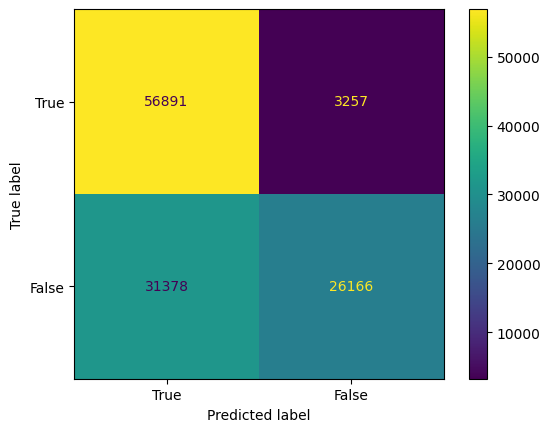

FPR: 0.05414976391567467 TPR: 0.4547129153343528


In [34]:
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()
plt.savefig('/kaggle/working/xception_cm.png')
plt.show()

fpr_cm = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tpr_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print("FPR:", fpr_cm, "TPR:", tpr_cm)

ROC: 0.700281575709339


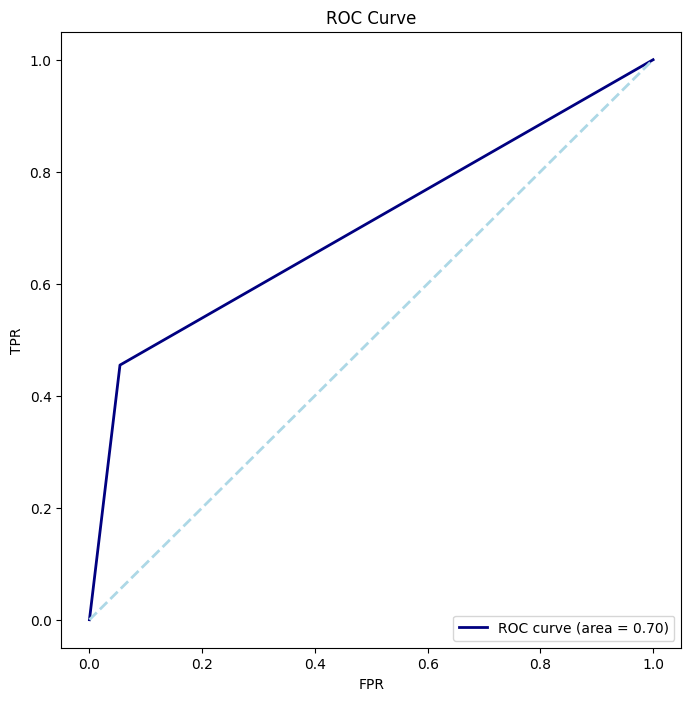

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC:",roc_auc)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/xception_roc.png')
plt.show()

PRC: 0.8053141778180788


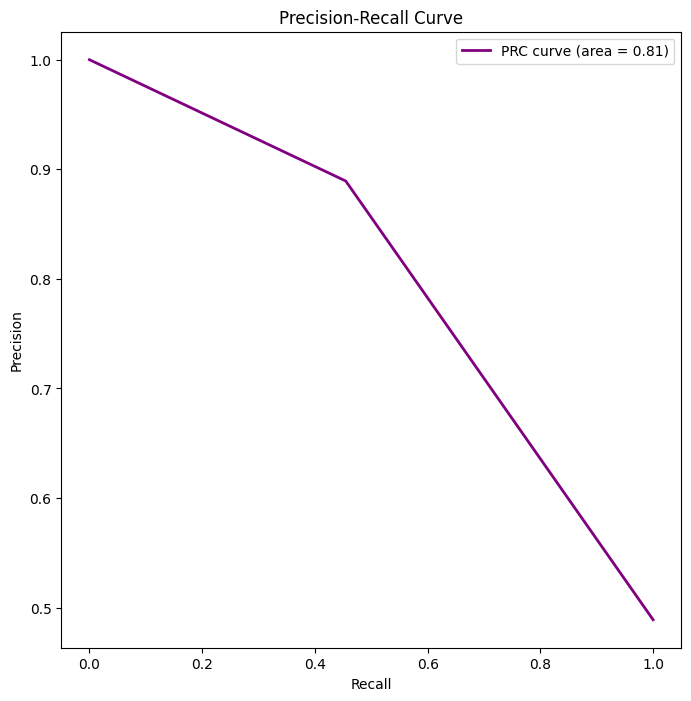

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
print("PRC:",prc_auc)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', lw=2, label='PRC curve (area = {:.2f})'.format(prc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('/kaggle/working/xception_prc.png')
plt.show()

In [37]:
f1_score_value = f1_score(y_test, y_pred, average='macro')
recall_score_value = recall_score(y_test, y_pred, average='macro')

print("F1 score:",f1_score_value,"recall score:", recall_score_value)

F1 score: 0.6841913673640116 recall score: 0.700281575709339


In [38]:
all_scores= {
    'F1 Score': f1_score_value,
    'Recall': recall_score_value,
    'FPR': fpr_cm,
    'TPR': tpr_cm,
    'ROC AUC': roc_auc,
    'PRC AUC': prc_auc
    }
print('F1 Score:', f1_score_value)
print('Recall:', recall_score_value)
print('FPR:', fpr_cm)
print('TPR:', tpr_cm)
print('ROC AUC:', roc_auc)
print('PRC AUC:', prc_auc)
print('All Scores:', all_scores)

F1 Score: 0.6841913673640116
Recall: 0.700281575709339
FPR: 0.05414976391567467
TPR: 0.4547129153343528
ROC AUC: 0.700281575709339
PRC AUC: 0.8053141778180788
All Scores: {'F1 Score': 0.6841913673640116, 'Recall': 0.700281575709339, 'FPR': 0.05414976391567467, 'TPR': 0.4547129153343528, 'ROC AUC': 0.700281575709339, 'PRC AUC': 0.8053141778180788}


In [39]:
import json
dict_string = json.dumps(all_scores)
file_path = '/kaggle/working/output.txt'

with open(file_path, 'w') as file:
    file.write(dict_string)

scores_table = pd.DataFrame({
    'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'],
    'Score': [f1_score_value, tpr_cm, fpr_cm]
})
scores_table.to_csv('/kaggle/working/scores_table.csv', index=False)
print(scores_table)

                Metric     Score
0             F1 Score  0.684191
1   True Positive Rate  0.454713
2  False Positive Rate  0.054150


In [40]:
arrays_ = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
arrays_.to_csv('/kaggle/working/pred_array_output_file.csv', index=False)

In [41]:
from tensorflow.keras.models import save_model
model.save('/kaggle/working/xception_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
pr_arrays = pd.DataFrame({'tpr':tpr,'fpr':fpr})
pr_arrays.to_csv('/kaggle/working/pr_array_output.csv',index= False)

In [44]:


import json

# Assuming tpr and fpr are NumPy arrays
print("Type of f1:", type(f1_score_value))
print("Type of precision:", type(precision))
print("Type of recall:", type(recall))
print("Type of tpr_value:", type(tpr_cm))
print("Type of fpr_value:", type(fpr_cm))
print("Type of roc_auc:", type(roc_auc))
print("Type of prc_auc:", type(prc_auc))
print("Type of tpr:", type(tpr))
print("Type of fpr:", type(fpr))

precision_list = precision.tolist()
recall_list = recall.tolist()
tpr_list = tpr.tolist()
fpr_list = fpr.tolist()

#print(f1.type())

data = {
    "Average F1 Score": float(f1_score_value), 
    #"Average Precision": float(precision_score_value), 
    "Average Recall": float(recall_score_value), 
    "Average True Positive Rate": float(tpr_cm), 
    "Average False Positive Rate": float(fpr_cm), 
    "Average ROC AUC": roc_auc, 
    "Average PRC AUC": prc_auc,
    "TPR Array" : tpr_list,
    "FPR Array" : fpr_list,
    "Precision Array": precision_list, 
    "Recall Array": recall_list
}

# Specify the file path
file_path = "/kaggle/working/Xception - Synthetic PCA - Lenny 2.json"

# Write the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

Type of f1: <class 'numpy.float64'>
Type of precision: <class 'numpy.ndarray'>
Type of recall: <class 'numpy.ndarray'>
Type of tpr_value: <class 'numpy.float64'>
Type of fpr_value: <class 'numpy.float64'>
Type of roc_auc: <class 'numpy.float64'>
Type of prc_auc: <class 'numpy.float64'>
Type of tpr: <class 'numpy.ndarray'>
Type of fpr: <class 'numpy.ndarray'>
